In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plot

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
features = np.loadtxt('features.txt')

In [3]:
labels = Path('labels.txt').read_text().split('\n')

## The data needs some cleaning

In [4]:
np.unique(labels)

array(['Female', 'Male', 'Masculino', 'Please Select', 'Weiblich',
       '[female];', '[male];', 'adult', 'female', 'make', 'male', 'male;',
       'unknown'], dtype='<U13')

### Set 1=male 2=female

In [5]:
male_words = ['Male', 'Masculino', '[male];', 'male', 'male;']
female_words = ['Female', 'Weiblich', 'female', '[female];']

clean_labels = []
clean_features=  []
for feature, label in zip(features, labels):
    if label in male_words:
        clean_features.append(feature)
        clean_labels.append(1)
    elif label in female_words:
        clean_features.append(feature)
        clean_labels.append(2)
        
features = np.array(clean_features)
labels = np.array(clean_labels)        

## Train/Test Split

In [6]:
train_x, test_x, train_y, test_y = train_test_split(features, labels)

## Rebalance the classes

In [7]:
male_features = train_x[train_y==1]
male_labels = train_y[train_y == 1]

female_features = train_x[train_y==2]
female_labels = train_y[train_y == 2]

female_features = np.row_stack([female_features] * int(len(male_labels)/len(female_labels)))
female_labels = np.concatenate([female_labels] * int(len(male_labels)/len(female_labels)))

train_x = np.row_stack((male_features, female_features))
train_y = np.concatenate((male_labels, female_labels))



## Make some plots

In [8]:
frequencies = 300* np.arange(len(train_x[0]))/len(train_x[0])

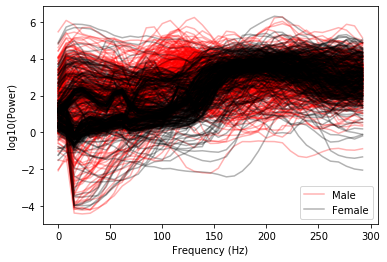

In [9]:
male_features = train_x[train_y==1]
male_labels = train_y[train_y == 1]

female_features = train_x[train_y==2]
female_labels = train_y[train_y == 2]

plot.plot(frequencies, np.log10(male_features[0]), alpha=0.3, color='r', label='Male')
plot.plot(frequencies, np.log10(female_features[0]), alpha=0.3, color='k', label='Female')

for choice in male_features[np.random.choice(list(range(len(male_features))), size=300)]:
    plot.plot(frequencies, np.log10(choice), alpha=0.3, color='r')
for choice in female_features[np.random.choice(list(range(len(female_features))), size=300)]:
    plot.plot(frequencies, np.log10(choice), alpha=0.3, color='k')
plot.xlabel('Frequency (Hz)')
plot.ylabel('log10(Power)')
plot.legend()

plot.savefig('psd.png')

## Train a Model

In [10]:
# model = RandomForestClassifier()
model = GradientBoostingClassifier(n_estimators=500, max_depth=5, subsample=0.8, verbose=1)
model.fit(train_x, train_y)

Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2474           0.1367           13.46m
         2           1.1335           0.1122           13.21m
         3           1.0396           0.0932           13.12m
         4           0.9582           0.0812           13.04m
         5           0.8871           0.0701           13.19m
         6           0.8266           0.0605           13.24m
         7           0.7719           0.0538           13.20m
         8           0.7248           0.0460           13.17m
         9           0.6808           0.0428           13.12m
        10           0.6449           0.0371           13.09m
        20           0.4278           0.0134           12.73m
        30           0.3308           0.0070           12.44m
        40           0.2808           0.0039           12.29m
        50           0.2460           0.0045           12.00m
        60           0.2207           0.0012           11.82m
        70   

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

## Evaluate it

In [12]:
print(classification_report(test_y, model.predict(test_x), target_names=['Male', 'Female']))

precision    recall  f1-score   support

        Male       0.99      0.98      0.99     15936
      Female       0.92      0.94      0.93      3007

    accuracy                           0.98     18943
   macro avg       0.95      0.96      0.96     18943
weighted avg       0.98      0.98      0.98     18943

